In [2]:
import json
import numpy as np
import pandas as pd

#import time
import datetime as dt
from datetime import datetime, timedelta,time

#visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.lines as mlines

#machine learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,normalize,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.exceptions import DataConversionWarning
import xgboost as xgb

## Inialization and Data Wrangling

In [4]:
# user information
file = 'takehome_users.csv'
user_df = pd.read_csv(file,encoding='latin-1')

file = 'takehome_users.csv'
user_df_unaltered = user_df


# login information
file = 'takehome_user_engagement.csv'
login_df = pd.read_csv(file,encoding='latin-1')
login_df['time_stamp'] =pd.to_datetime(login_df['time_stamp']) 

#number of logins
user_df = user_df.merge(login_df.groupby('user_id').sum().reset_index(),
              how='left',left_on='object_id',right_on='user_id').drop(['user_id'],axis=1)
user_df['visited'] = user_df['visited'].fillna(0)

#convert creation_time into date time
#user_df['creation_time'] = pd.to_datetime(user_df['creation_time'])

#convert last_session_creation_time into datetime and fill nan values with creation_time
user_df['last_session_creation_time'] = user_df[['last_session_creation_time','creation_time']].apply(
    lambda x:datetime.utcfromtimestamp(x[0])
    if not np.isnan(x[0])
    else x[1],axis=1)

#replace time with days in system
user_df['days in system']=user_df[['creation_time','last_session_creation_time']].apply(
    lambda x: (x[1]-x[0]).days,axis=1)

#dummy column for creation_source source
source_df = pd.get_dummies(user_df['creation_source'],drop_first=True)
user_df = user_df.join(source_df)

# bool if invite by user
user_df['invited_by_user'] = (user_df['invited_by_user_id'].apply(lambda x: True if not np.isnan(x) else False))

#figuring out which users are 'adopted users'
adopted_users = []
for user_index in login_df['user_id'].unique():
    user_login = login_df[login_df['user_id']==user_index]
    for start_date in user_login['time_stamp']:
        end_date = start_date + timedelta(days=7)
        mask = (user_login['time_stamp'] >= start_date) & (user_login['time_stamp'] < end_date)
        login_sum = user_login[mask]['visited'].sum()
        if login_sum >= 3:
            adopted_users.append((user_index,True))
            break
adopted_df =  pd.DataFrame(adopted_users,columns=['object_id','adopted_user'])
user_df=user_df.merge(adopted_df,how='left',on='object_id')
user_df['adopted_user'] = user_df['adopted_user'].fillna(False)

#removing unnessary columns
user_df.drop(['name','email','org_id','creation_source','creation_time','last_session_creation_time','invited_by_user_id'],axis=1,inplace=True)


#change types 0,1 int to bools
user_df['enabled_for_marketing_drip'] = user_df['enabled_for_marketing_drip'].astype(bool) 
user_df['opted_in_to_mailing_list'] = user_df['opted_in_to_mailing_list'].astype(bool) 

#set id to the index
user_df.set_index('object_id',inplace=True)


#delete unnessary dataframes
del source_df
del adopted_users
del adopted_df

## Visualization

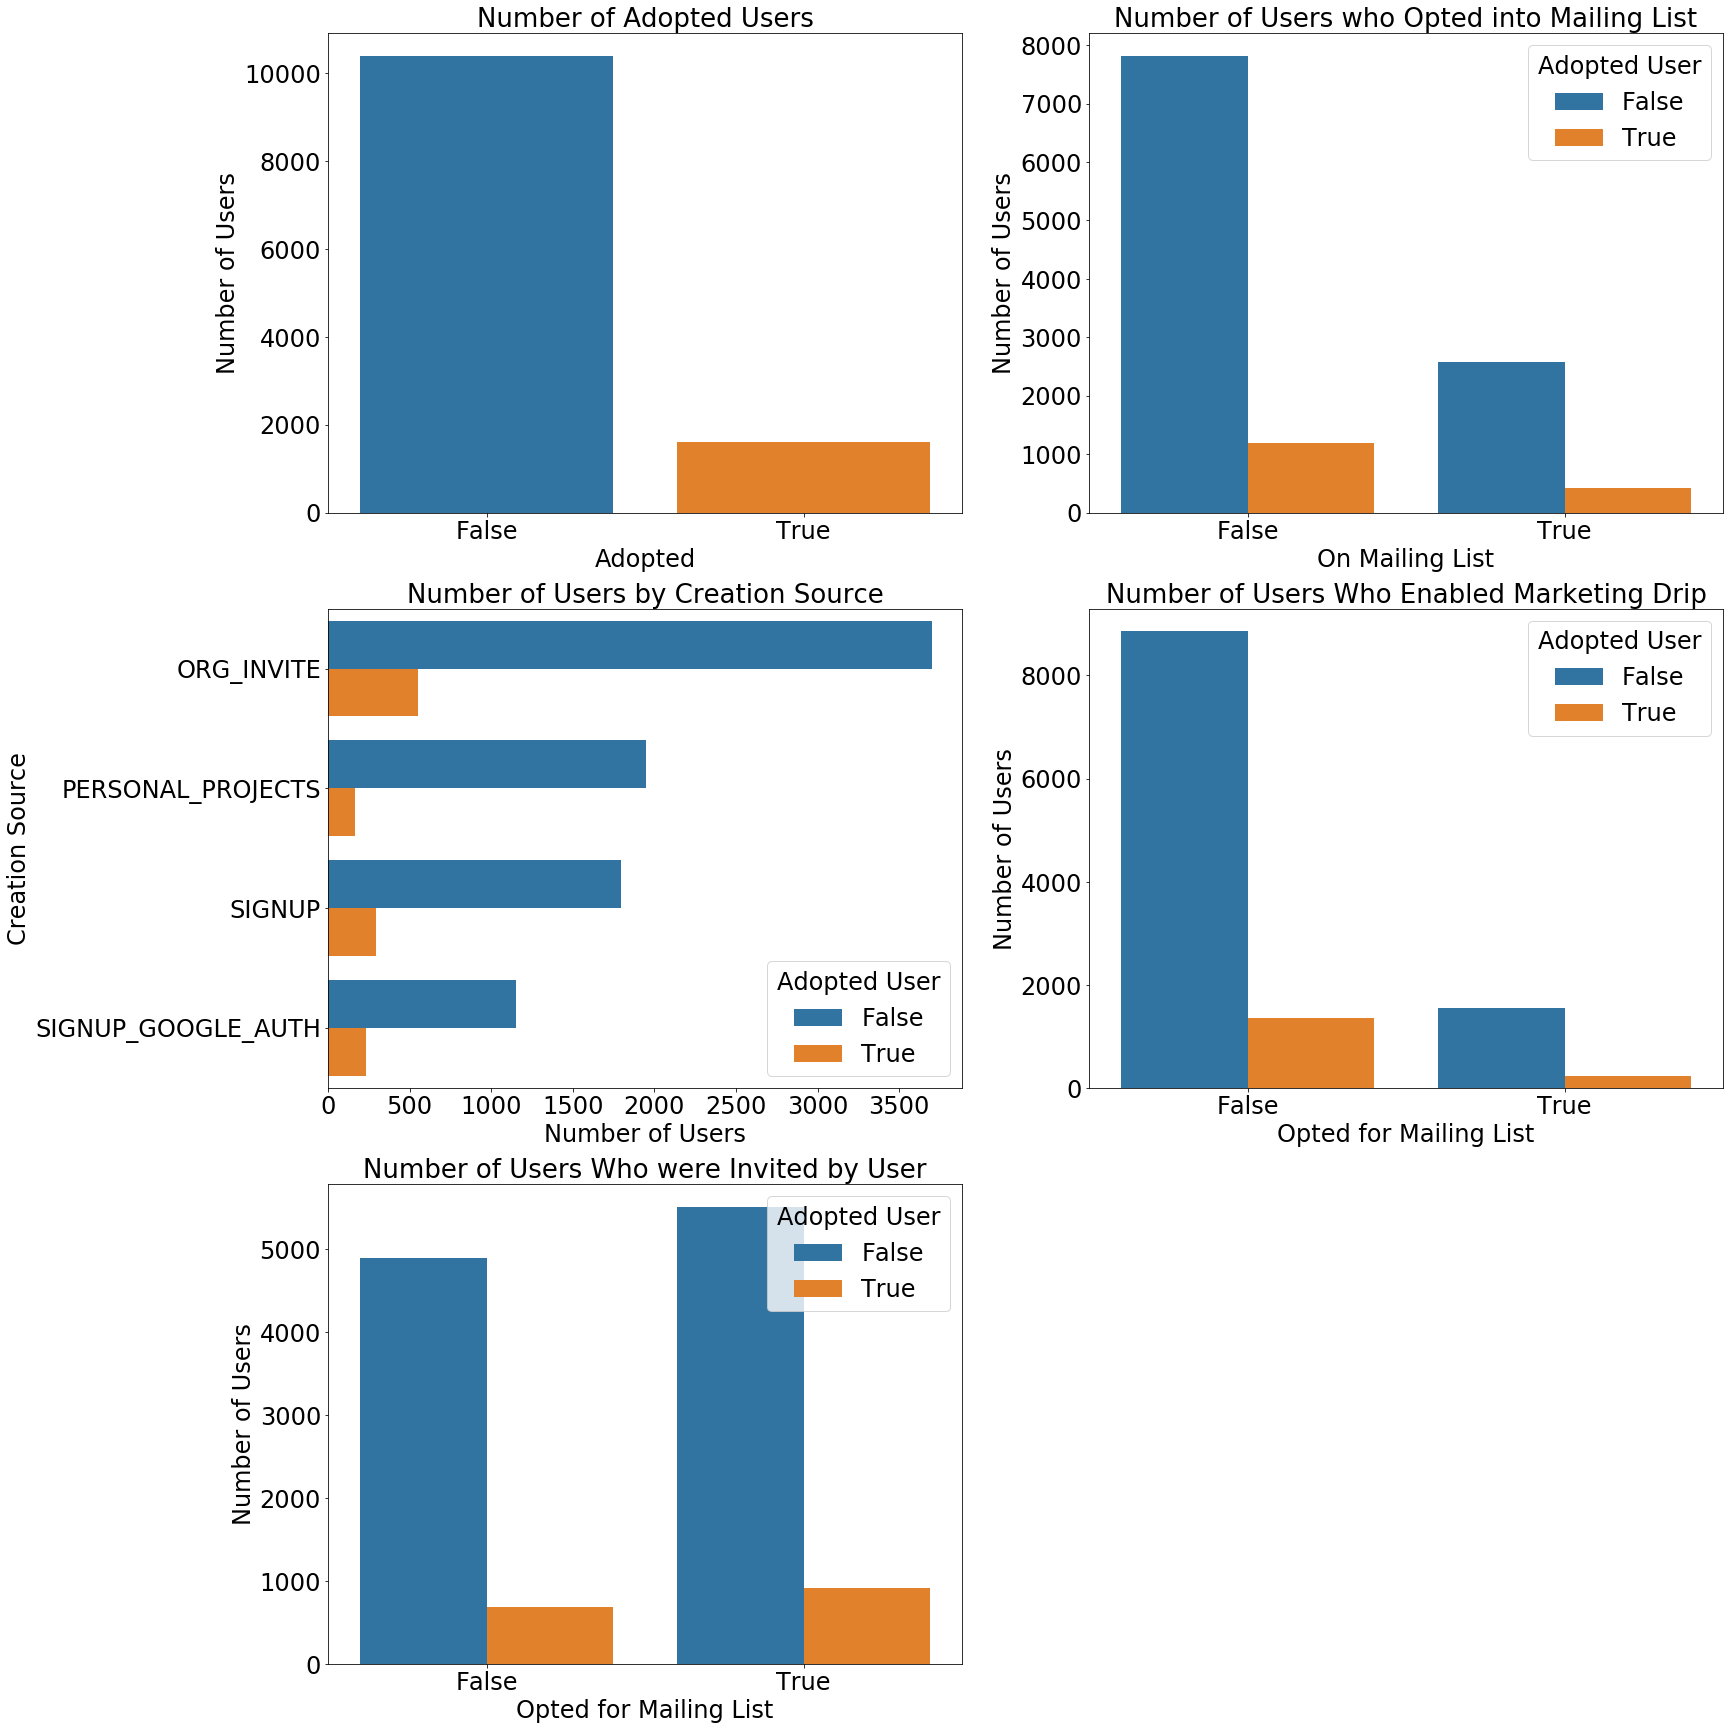

In [14]:
adopted_df = user_df[user_df['adopted_user']]
nonadopted_df = user_df[~user_df['adopted_user']]
fig = plt.figure(figsize=(25,30)) 

titlesize = 26
textsize = 24

ax1 = fig.add_subplot(3,2,1)
sns.barplot(x='adopted_user',
             y='opted_in_to_mailing_list',
             data=user_df.groupby('adopted_user').count().reset_index(),
             ax=ax1)
plt.yticks(fontsize=textsize)
plt.xticks(fontsize=textsize)
ax1.set_title('Number of Adopted Users',fontsize=titlesize)
ax1.set_xlabel('Adopted',fontsize=textsize)
ax1.set_ylabel('Number of Users',fontsize=textsize)


ax2 = fig.add_subplot(3,2,2)
sns.barplot(x='opted_in_to_mailing_list',
             y='enabled_for_marketing_drip',
             data=user_df.groupby(['adopted_user','opted_in_to_mailing_list']).count().reset_index(),
             hue='adopted_user',
             ax=ax2)
plt.yticks(fontsize=textsize)
plt.xticks(fontsize=textsize)
ax2.set_title('Number of Users who Opted into Mailing List',fontsize=titlesize)
ax2.set_xlabel('On Mailing List',fontsize=textsize)
ax2.set_ylabel('Number of Users',fontsize=textsize)
legend = plt.legend(fontsize=textsize, title='Adopted User')
legend.get_title().set_fontsize(textsize)


creation_df =user_df.groupby('adopted_user').sum()[['ORG_INVITE','PERSONAL_PROJECTS','SIGNUP','SIGNUP_GOOGLE_AUTH']].reset_index()
creation_melt =pd.melt(creation_df, id_vars="adopted_user", var_name="creation_source", value_name="count")

ax3 = fig.add_subplot(3,2,3)
sns.barplot(x='count',
             data=creation_melt,
             y='creation_source',
             hue='adopted_user')
plt.yticks(fontsize=textsize)
plt.xticks(fontsize=textsize)
ax3.set_title('Number of Users by Creation Source',fontsize=titlesize)
ax3.set_ylabel('Creation Source',fontsize=textsize)
ax3.set_xlabel('Number of Users',fontsize=textsize)
legend = plt.legend(fontsize=textsize, title='Adopted User')
legend.get_title().set_fontsize(textsize)

ax4 = fig.add_subplot(3,2,4)
sns.barplot(x='enabled_for_marketing_drip',
             y='opted_in_to_mailing_list',
             data=user_df.groupby(['adopted_user','enabled_for_marketing_drip']).count().reset_index(),
             hue='adopted_user',
             ax=ax4)
plt.yticks(fontsize=textsize)
plt.xticks(fontsize=textsize)
ax4.set_title('Number of Users Who Enabled Marketing Drip',fontsize=titlesize)
ax4.set_xlabel('Opted for Mailing List',fontsize=textsize)
ax4.set_ylabel('Number of Users',fontsize=textsize)
legend = plt.legend(fontsize=textsize, title='Adopted User')
legend.get_title().set_fontsize(textsize)

ax5 = fig.add_subplot(3,2,5)
sns.barplot(x='invited_by_user',
             y='enabled_for_marketing_drip',
             data=user_df.groupby(['adopted_user','invited_by_user']).count().reset_index(),
             hue='adopted_user',
             ax=ax5)
plt.yticks(fontsize=textsize)
plt.xticks(fontsize=textsize)
ax5.set_title('Number of Users Who were Invited by User',fontsize=titlesize)
ax5.set_xlabel('Opted for Mailing List',fontsize=textsize)
ax5.set_ylabel('Number of Users',fontsize=textsize)
legend = plt.legend(fontsize=textsize, title='Adopted User')
legend.get_title().set_fontsize(textsize)

plt.savefig('barplot.jpg',bbox_inches='tight')

plt.show()

# Gradient Boosting without number of visits or days in system

In [492]:
X = user_df.drop(['adopted_user','visited','days in system'],axis=1)
y = user_df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42)

params = {}
xgboost = xgb.XGBClassifier(num_boost_round=10,objective='binary:logistic',silent=1)
param_grid = { 
        'n_estimators':range(100,1100,100),
        'learning_rate':np.arange(.01,0.11,.01),
        'min_child_weight': range(0,11,1),
        'gamma': np.arange(.1,5,.1),
        'subsample': np.arange(.1,1.1,.1),
        'colsample_bytree': np.arange(.1,1.1,.1),
        'max_depth': range(0,11,1)}

grid_xgb = RandomizedSearchCV(estimator=xgboost,param_distributions=param_grid,cv=4,scoring="f1_micro",
                              n_iter=40,random_state=42)    

grid_xgb.fit(X_train,y_train)
y_pred = grid_xgb.predict(X_test)

# measure accuracy 
print('model accuarcy = {:.4f}'.format(accuracy_score(y_test,y_pred)))
print('f1 score = {:.4f}'.format(metrics.f1_score(y_test,y_pred)))
print('precision = {:.4f}'.format(metrics.precision_score(y_test,y_pred)))
print('recall = {:.4f}'.format(metrics.recall_score(y_test,y_pred)))
print('confusion_matrix \n {}'.format(metrics.confusion_matrix(y_test,y_pred)))

/home/yoni/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


model accuarcy = 0.8650
f1 score = 0.0000
precision = 0.0000
recall = 0.0000
confusion_matrix 
 [[3114    0]
 [ 486    0]]


/home/yoni/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/yoni/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Gradient Boosting  with number of visits or days in system

In [502]:
X = user_df.drop(['adopted_user'],axis=1)
y = user_df['adopted_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42)

params = {}
xgboost = xgb.XGBClassifier(num_boost_round=10,objective='binary:logistic',silent=1)
param_grid = { 
        'n_estimators':range(100,1100,100),
        'learning_rate':np.arange(.01,0.11,.01),
        'min_child_weight': range(0,11,1),
        'gamma': np.arange(.1,5,.1),
        'subsample': np.arange(.1,1.1,.1),
        'colsample_bytree': np.arange(.1,1.1,.1),
        'max_depth': range(0,11,1)}

grid_xgb = RandomizedSearchCV(estimator=xgboost,param_distributions=param_grid,cv=4,scoring="f1_micro",
                              n_iter=40,random_state=42)    

grid_xgb.fit(X_train,y_train)
y_pred = grid_xgb.predict(X_test)
print('accuracy = {:.3f}'.format(accuracy_score(y_test,y_pred)))

/home/yoni/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


accuracy = 0.988


In [503]:
# messure accuracy 
print('model accuracy = {:.4f}'.format(accuracy_score(y_test,y_pred)))
print('f1 score = {:.4f}'.format(metrics.f1_score(y_test,y_pred)))
print('precision = {:.4f}'.format(metrics.precision_score(y_test,y_pred)))
print('recall = {:.4f}'.format(metrics.recall_score(y_test,y_pred)))
print('confusion_matrix \n {}'.format(metrics.confusion_matrix(y_test,y_pred)))

model accuracy = 0.9875
f1 score = 0.9532
precision = 0.9642
recall = 0.9424
confusion_matrix 
 [[3097   17]
 [  28  458]]


In [491]:
feature_df = pd.DataFrame(grid_xgb.best_estimator_.feature_importances_,
                          index=X_train.columns,columns=['feature importance'])
feature_df.sort_values(by='feature importance',axis=0,ascending=False)

,feature importance
visited,0.662562
days in system,0.295566
ORG_INVITE,0.021675
opted_in_to_mailing_list,0.008374
invited_by_user,0.006897
SIGNUP_GOOGLE_AUTH,0.004433
enabled_for_marketing_drip,0.000493
PERSONAL_PROJECTS,0.000000
SIGNUP,0.000000
